In [50]:
import numpy as np
import pickle 
from evaluation import Evaluator
import torch
import copy

### Evaluating embeddings

In [51]:
with open('embeddings/roberta_semeval.pkl', 'rb') as f:
    activations_dict_full = pickle.load(f)

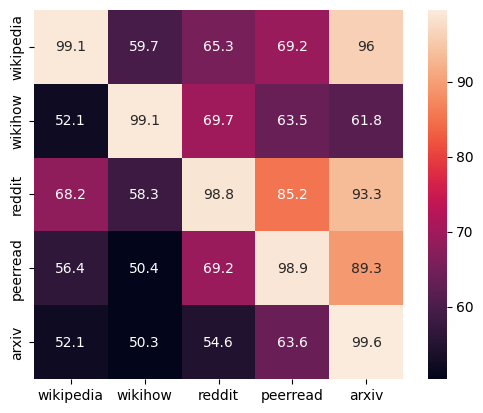

In [52]:
evaluator_cd = Evaluator(concat_axis='model')
evaluator_cd.fit(activations_dict_full, class_weight='balanced')
evaluator_cd.plot_heatmap()

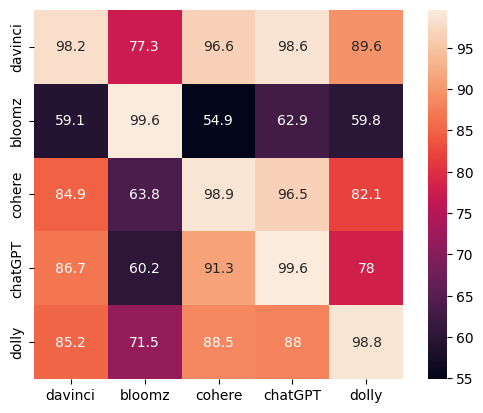

In [53]:
evaluator_cm = Evaluator(concat_axis='domain')
evaluator_cm.fit(activations_dict_full, class_weight='balanced')
evaluator_cm.plot_heatmap()

## Aggregating results

In [54]:
cd_scores = evaluator_cd.get_scores()
cm_results = evaluator_cm.get_scores()

print(f'Average cross-domain score: {cd_scores.mean()}')
print(f'Average cross-model score: {cm_results.mean()}')

Average cross-domain score: 72.95039957670656
Average cross-model score: 82.82322998337726


In [55]:
## removing in-domain results
np.fill_diagonal(cd_scores, np.nan)
np.fill_diagonal(cm_results, np.nan)

cd_transfer_from = np.nanmean(cd_scores, axis = 1)
cd_transfer_to = np.nanmean(cd_scores, axis = 0)

print('Average score transferring from domain:')
for i, domain in enumerate(evaluator_cd.axis_labels):
    print(f"{domain}: {cd_transfer_from[i]}")

Average score transferring from domain:
wikipedia: 72.5476116129036
wikihow: 61.75048957009159
reddit: 76.28156426518835
peerread: 66.30735300870458
arxiv: 55.154422652796576


## Erasing concept

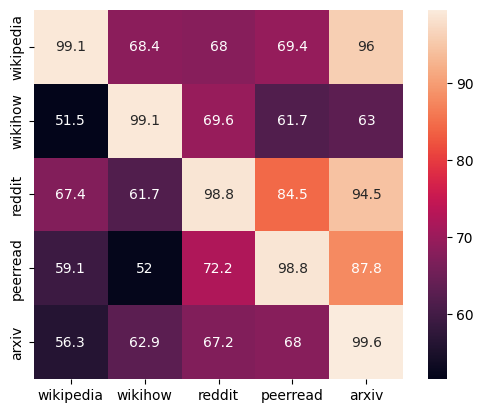

In [56]:
def erase_concept(activations_dict, task_name, model_name):
    with open(f'erasers/{task_name}_{model_name}.pkl', 'rb') as f:
        eraser = pickle.load(f)
    for m in activations_dict.keys():
        for d in activations_dict[m].keys():
            X_t = torch.from_numpy(np.array(activations_dict[m][d])).float()
            X_ = eraser(X_t)
            activations_dict[m][d] = X_.numpy()
    return activations_dict

evaluator_erased = Evaluator(concat_axis='model')

activations_dict_erased = erase_concept(copy.deepcopy(activations_dict_full), 'top_constituents', 'roberta')

evaluator_erased.fit(activations_dict_erased, class_weight='balanced')
evaluator_erased.plot_heatmap()